# Processing & Analysis of Biotek Plate Reader Records: Fold-change Induction

© 2019 Zofii Kaczmarek. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

--- 

In [291]:
import sys
sys.path.insert(0, '../../')
import numpy as np
import pandas as pd
import string
import os
import matplotlib.pyplot as plt
import mwc.viz
colors = mwc.viz.personal_style()

In [446]:
# Define the experimental constants
DATE = 20190521
RUN_NO = 3

# Create translation maps
alpha_map = {alpha:no for alpha, no in zip(string.ascii_uppercase, np.arange(0, 27, 1) * 12)}
alphanumeric_map = {f'{a}{n}':alpha_map[a] + n for n in np.arange(1, 13, 1) for a in string.ascii_uppercase}
row_letters = {no:alpha for no, alpha in zip(np.arange(0, 27, 1),string.ascii_uppercase)}

# Load the data. 
data = pd.read_csv(f'../../data/plate_reader/{DATE}_r{RUN_NO}_glucose_ind_induction.csv', skiprows=52)

## Tidy the Data

First, change the row under "Results" to: row,1,2,3,4,5,6,7,8,9,10,11,12,measurement,max_nm

In [447]:
# Remove column of max excitation wavelengths
data.drop(columns = ['max_nm'], inplace = True)

# Fill in missing row letters
data['row'] = [row_letters[np.floor(i/3)] for i in data.index]

# Melt to longform tidy
data = data.melt(id_vars = ['row','measurement'])

# Create columns of well ids
data['well_pos'] = data['row'].astype('str')+data['variable'].astype('str')

# Pivot to get each well in a single row
data = data.pivot(index = 'well_pos', columns='measurement',values='value').reset_index()
data['row'] = data['well_pos'].str[:1]
data['column'] = data['well_pos'].str[1:].astype('int')

# Define strains and repressor copy number dictionaries
strain_rows = {**{'A':'autofluoresence'},**{'B':'delta'},**{row:'rep' for row in ['C','D','E','F','G','H']}}
repressor_rows = {**{'A':0},**{'B':0},**{'C':22},**{'D':60},**{'E':124},**{'F':260},**{'G':1220},**{'H':1740}}
iptg_cols = {col:conc for (col,conc) in list(zip(np.arange(1,13),[0,0.1,5,10,25,50,75,100,250,500,1000,5000]))}

# Create columns of strain, IPTG concentration, repressor copy number, and well ids
data['strain'] = [strain_rows[r] for r in data['row']]
data['repressor_num'] = [repressor_rows[r] for r in data['row']]
data['IPTG_µM'] = [iptg_cols[c] for c in data['column']]

# Rename columns and sort
data.rename(columns = {'Read 1:600':'OD_600nm','Read 2:500':'YFP_intensity',
                       'Read 2:579':'mCherry_intensity'}, inplace=True)
data = data[['row','column','well_pos','strain','repressor_num','IPTG_µM','OD_600nm','YFP_intensity','mCherry_intensity']]
data = data.sort_values(['row','column'])

In [448]:
data.head()

measurement,row,column,well_pos,strain,repressor_num,IPTG_µM,OD_600nm,YFP_intensity,mCherry_intensity
0,A,1,A1,autofluoresence,0,0.0,0.151,366.0,292.0
4,A,2,A2,autofluoresence,0,0.1,0.146,368.0,269.0
5,A,3,A3,autofluoresence,0,5.0,0.138,345.0,258.0
6,A,4,A4,autofluoresence,0,10.0,0.135,390.0,241.0
7,A,5,A5,autofluoresence,0,25.0,0.126,338.0,241.0


## Calculate Foldchange

### Normalize Fluoresence Intensities to ODs

In [449]:
# Divide intensities of each well by OD_600nm of that well, to correct for cell density.
data['YFP_norm'] = data['YFP_intensity']/data['OD_600nm']
data['mCherry_norm'] = data['mCherry_intensity']/data['OD_600nm']

In [450]:
data.head()

measurement,row,column,well_pos,strain,repressor_num,IPTG_µM,OD_600nm,YFP_intensity,mCherry_intensity,YFP_norm,mCherry_norm
0,A,1,A1,autofluoresence,0,0.0,0.151,366.0,292.0,2423.841060,1933.774834
4,A,2,A2,autofluoresence,0,0.1,0.146,368.0,269.0,2520.547945,1842.465753
5,A,3,A3,autofluoresence,0,5.0,0.138,345.0,258.0,2500.000000,1869.565217
6,A,4,A4,autofluoresence,0,10.0,0.135,390.0,241.0,2888.888889,1785.185185
7,A,5,A5,autofluoresence,0,25.0,0.126,338.0,241.0,2682.539683,1912.698413


### Calculate YFP Foldchange

In [451]:
# Get dictionaries of auto and delta intensities at each [IPTG].
auto_dict = {}
delta_dict = {}
for conc in data['IPTG_µM'].unique():
    auto = data[(data['strain']=='autofluoresence')&(data['IPTG_µM']==conc)]['YFP_norm'].values[0]
    delta = data[(data['strain']=='delta')&(data['IPTG_µM']==conc)]['YFP_norm'].values[0]
    auto_dict.update([(conc,auto)])
    delta_dict.update([(conc,delta)])

In [452]:
# For each [IPTG], subtract `autofluoresence` YFP from `rep` YFP, and also from `delta` YFP, 
# and take the ratio of the two.
data['foldchange'] = [(yfp-auto)/(delta-auto) for (yfp,auto,delta) in 
                      zip(data['YFP_norm'], 
                          [auto_dict[conc] for conc in data['IPTG_µM']],
                          [delta_dict[conc] for conc in data['IPTG_µM']])]

In [453]:
# For 20190521_r2, exclude column 10, which didn't grow.
if RUN_NO == 2: data = data[data['column']!=10]

## Save Dataframe

In [454]:
data['date'] = DATE
data['run'] = RUN_NO
data.to_csv(f'{DATE}_r{RUN_NO}_processed_fluo.csv', index=False)

## Plot the Data For a Single Run

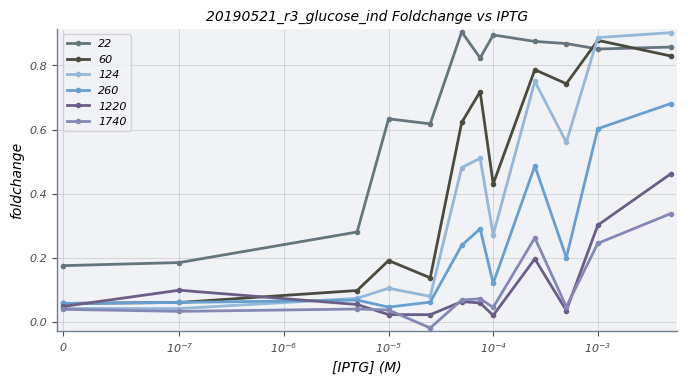

In [455]:
# Plot the foldchange data. 
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.set_xlabel('[IPTG] (M)', fontsize=10)
ax.set_ylabel('foldchange', fontsize=10)

for rep_num in data['repressor_num'].unique()[1:]:
    dat = data[data['repressor_num']==rep_num]
    ax.plot(dat['IPTG_µM']*10**-6,dat['foldchange'],label = rep_num,marker= '.')
ax.set_xscale('symlog',linthreshx=10**-7)
ax.legend()
ax.set_title(f'{DATE}_r{RUN_NO}_glucose_ind Foldchange vs IPTG', fontsize = 10)
plt.savefig(f'{DATE}_r{RUN_NO}_glucose_ind_Foldchange_vs_IPTG.png')

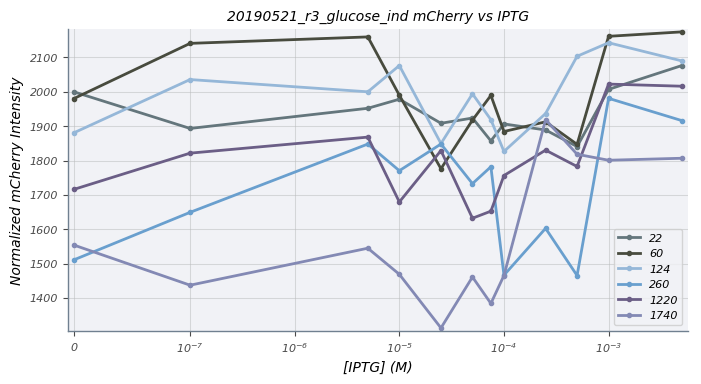

In [456]:
# Plot the mCherry (volume marker) data. 
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.set_xlabel('[IPTG] (M)', fontsize=10)
ax.set_ylabel('Normalized mCherry Intensity', fontsize=10)

for rep_num in data['repressor_num'].unique()[1:]:
    dat = data[data['repressor_num']==rep_num]
    ax.plot(dat['IPTG_µM']*10**-6,dat['mCherry_norm'],label = rep_num,marker= '.')
ax.set_xscale('symlog',linthreshx=10**-7)
ax.legend()
ax.set_title(f'{DATE}_r{RUN_NO}_glucose_ind mCherry vs IPTG', fontsize = 10)
plt.savefig(f'{DATE}_r{RUN_NO}_glucose_ind_mCherry_vs_IPTG.png')

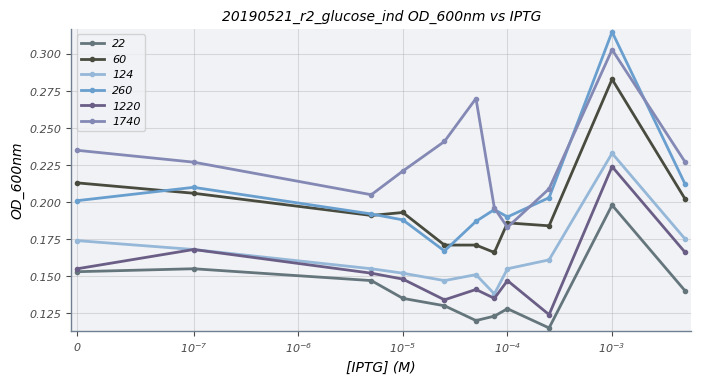

In [474]:
# Plot the OD data. 
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.set_xlabel('[IPTG] (M)', fontsize=10)
ax.set_ylabel('OD_600nm', fontsize=10)

for rep_num in data['repressor_num'].unique()[1:]:
    dat = data[data['repressor_num']==rep_num]
    ax.plot(dat['IPTG_µM']*10**-6,dat['OD_600nm'],label = rep_num,marker= '.')
ax.set_xscale('symlog',linthreshx=10**-7)
ax.legend()
ax.set_title(f'{DATE}_r{RUN_NO}_glucose_ind OD_600nm vs IPTG', fontsize = 10)
plt.savefig(f'{DATE}_r{RUN_NO}_glucose_ind_OD_vs_IPTG.png')

## Analyze Replicates Together

In [475]:
run1 = pd.read_csv(f'{DATE}_r1_processed_fluo.csv')
run2 = pd.read_csv(f'{DATE}_r2_processed_fluo.csv')
run3 = pd.read_csv(f'{DATE}_r3_processed_fluo.csv')

In [476]:
data = pd.concat([run1,run2,run3])

In [477]:
data_avgd = data.groupby(
    ['strain','repressor_num','IPTG_µM','date'])['foldchange','mCherry_norm','OD_600nm'].agg(
    ['mean','std','sem'])
data_avgd.columns = ['_'.join(col) for col in data_avgd.columns.values]
data_avgd = data_avgd.reset_index()

### Plot Means

In [478]:
data_avgd.head()

,strain,repressor_num,IPTG_µM,date,foldchange_mean,foldchange_std,foldchange_sem,mCherry_norm_mean,mCherry_norm_std,mCherry_norm_sem,OD_600nm_mean,OD_600nm_std,OD_600nm_sem
0,autofluoresence,0,0.0,20190521,0.0,0.0,0.0,1757.859796,238.576756,137.742355,0.151333,0.005508,0.003180
1,autofluoresence,0,0.1,20190521,0.0,0.0,0.0,1674.334531,149.890355,86.539237,0.140333,0.010693,0.006173
2,autofluoresence,0,5.0,20190521,0.0,0.0,0.0,1692.110712,185.218022,106.935675,0.135667,0.002517,0.001453
3,autofluoresence,0,10.0,20190521,0.0,0.0,0.0,1747.252932,81.643937,47.137149,0.131333,0.004041,0.002333
4,autofluoresence,0,25.0,20190521,0.0,0.0,0.0,1754.108426,170.001283,98.150286,0.126667,0.007024,0.004055


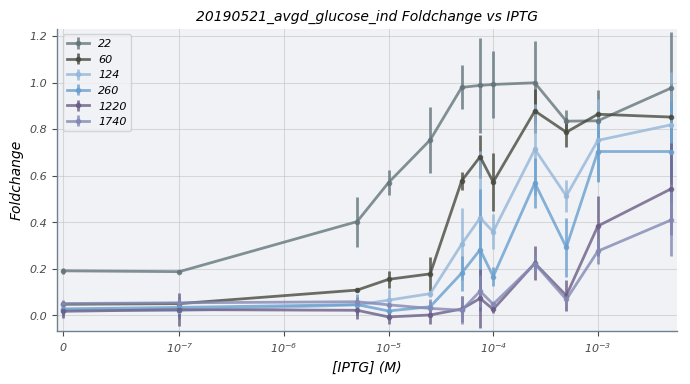

In [479]:
# Plot the foldchange data. 
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.set_xlabel('[IPTG] (M)', fontsize=10)
ax.set_ylabel('Foldchange', fontsize=10)

for rep_num in data_avgd['repressor_num'].unique()[1:]:
    dat = data_avgd[data_avgd['repressor_num']==rep_num]
    ax.errorbar(dat['IPTG_µM']*10**-6,dat['foldchange_mean'],
                yerr = dat['foldchange_std'], label = rep_num, fmt = '.-',alpha = 0.8)
ax.set_xscale('symlog',linthreshx=10**-7)
ax.legend()
ax.set_title(f'{DATE}_avgd_glucose_ind Foldchange vs IPTG', fontsize = 10)
plt.savefig(f'{DATE}_avgd_glucose_ind_Foldchange_vs_IPTG.png')

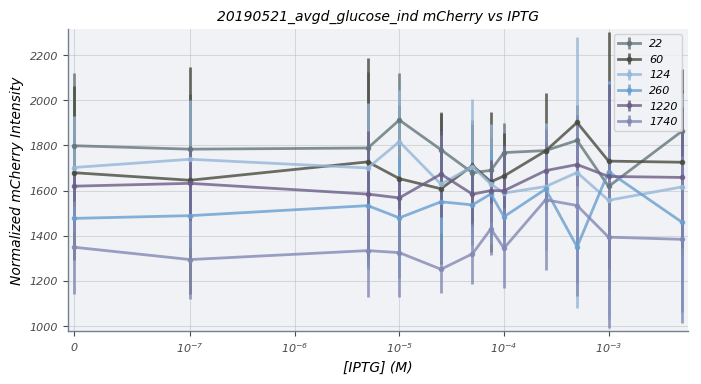

In [480]:
# Plot the mCherry (volume marker) data. 
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.set_xlabel('[IPTG] (M)', fontsize=10)
ax.set_ylabel('Normalized mCherry Intensity', fontsize=10)

for rep_num in data_avgd['repressor_num'].unique()[1:]:
    dat = data_avgd[data_avgd['repressor_num']==rep_num]
    ax.errorbar(dat['IPTG_µM']*10**-6,dat['mCherry_norm_mean'],
                yerr = dat['mCherry_norm_std'], label = rep_num, fmt = '.-',alpha = 0.8)
ax.set_xscale('symlog',linthreshx=10**-7)
ax.legend()
ax.set_title(f'{DATE}_avgd_glucose_ind mCherry vs IPTG', fontsize = 10)
plt.savefig(f'{DATE}_avgd_glucose_ind_mCherry_vs_IPTG.png')

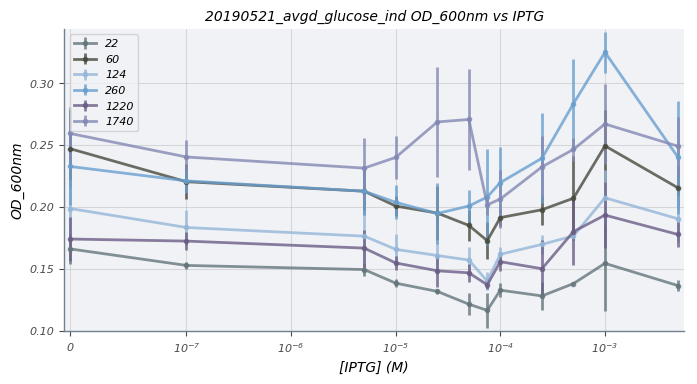

In [481]:
# Plot the OD data. 
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.set_xlabel('[IPTG] (M)', fontsize=10)
ax.set_ylabel('OD_600nm', fontsize=10)

for rep_num in data_avgd['repressor_num'].unique()[1:]:
    dat = data_avgd[data_avgd['repressor_num']==rep_num]
    ax.errorbar(dat['IPTG_µM']*10**-6,dat['OD_600nm_mean'],
                yerr = dat['OD_600nm_std'], label = rep_num, fmt = '.-',alpha = 0.8)
ax.set_xscale('symlog',linthreshx=10**-7)
ax.legend()
ax.set_title(f'{DATE}_avgd_glucose_ind OD_600nm vs IPTG', fontsize = 10)
plt.savefig(f'{DATE}_avgd_glucose_ind_OD_vs_IPTG.png')